<a href="https://colab.research.google.com/github/CubeVic/Machine_Learning/blob/main/%5BFreeCodeCamp%5D%5B005%5Dsms_text_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

---

In this challenge, you need to create a machine learning model that will classify SMS messages as either "ham" or "spam". A "ham" message is a normal message sent by a friend. A "spam" message is an advertisement or a message sent by a company.

You should create a function called `predict_message` that takes a message string as an argument and returns a list.
 
* The first element in the list should be a number between zero and one that indicates the likeliness of "ham" (0) or "spam" (1).

*   The second element in the list should be the word "ham" or "spam", depending on which is most likely.



For this challenge, you will use the [SMS Spam Collection dataset](http://www.dt.fee.unicamp.br/~tiago/smsspamcollection/). The dataset has already been grouped into train data and test data.

The first two cells import the libraries and data. The final cell tests your model and function. Add your code in between these cells.


In [ ]:
# import libraries
try:
  # %tensorflow_version only exists in Colab.
  !pip install tf-nightly
except Exception:
  pass
import tensorflow as tf
import pandas as pd
from tensorflow import keras
!pip install tensorflow-datasets
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt

print(tf.__version__)

     |████████████████████████████████| 392.0MB 36kB/s 
     |████████████████████████████████| 471kB 55.5MB/s 
     |████████████████████████████████| 10.6MB 51.0MB/s 
2.4.0-dev20201007


In [ ]:
# get data files
TRAIN_DATA_URL = "https://raw.githubusercontent.com/beaucarnes/fcc_python_curriculum/master/sms/train-data.tsv"
TEST_DATA_URL = "https://raw.githubusercontent.com/beaucarnes/fcc_python_curriculum/master/sms/valid-data.tsv"

train_file_path = tf.keras.utils.get_file("train-data.tsv", TRAIN_DATA_URL)
test_file_path = tf.keras.utils.get_file("valid-data.tsv", TEST_DATA_URL)

122880/118774 [===============================] - 0s 0us/step


## Exploring the data

### Reading the data

In [ ]:
train_dataset = pd.read_csv(train_file_path, 
                            sep='\t', 
                            header=None, 
                            names=['type_sms','Message'])
test_dataset = pd.read_csv(test_file_path, 
                           sep='\t', 
                           header=None, 
                           names=['type_sms','Message'])
train_dataset

,type_sms,Message
0,ham,ahhhh...just woken up!had a bad dream about u ...
1,ham,you can never do nothing
2,ham,"now u sound like manky scouse boy steve,like! ..."
3,ham,mum say we wan to go then go... then she can s...
4,ham,never y lei... i v lazy... got wat? dat day ü ...
...,...,...
4174,ham,just woke up. yeesh its late. but i didn't fal...
4175,ham,what do u reckon as need 2 arrange transport i...
4176,spam,free entry into our £250 weekly competition ju...
4177,spam,-pls stop bootydelious (32/f) is inviting you ...


Check what type of content do we have

In [ ]:
train_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4179 entries, 0 to 4178
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   type_sms  4179 non-null   object
 1   Message   4179 non-null   object
dtypes: object(2)
memory usage: 65.4+ KB


In [ ]:
train_dataset.describe()

,type_sms,Message
count,4179,4179
unique,2,3935
top,ham,"sorry, i'll call later"
freq,3619,22


Now let check what is ne most common message in both categories, and see if the dataset is **Unbalanced** 

In [ ]:
train_dataset.groupby('type_sms').describe().T

type_sms                           ham                                               spam
Message count                     3619                                                560
        unique                    3430                                                505
        top     sorry, i'll call later  hmv bonus special 500 pounds of genuine hmv vo...
        freq                        22                                                  3

To further explore the information I will divide the 'ham' and 'spam' message and generate a numpy list that later will be use to create a wordCloud, and bar chart

In [ ]:
#get the ham and spam messagers
spam_msg = train_dataset[train_dataset.type_sms == 'spam']
ham_msg = train_dataset[train_dataset.type_sms == 'ham']

In [ ]:
print(f"shape of ham messages: {ham_msg.shape}\nshape of spam message: {spam_msg.shape}")

shape of ham messages: (3619, 2)
shape of spam message: (560, 2)


In [ ]:
#create the numpy list to use on the wordcloud
spam_msg_text = " ".join(spam_msg.Message.to_numpy().tolist())
ham_msg_text = " ".join(ham_msg.Message.to_numpy().tolist())

In [ ]:
spam_msg_text

"urgent! call 09066350750 from your landline. your complimentary 4* ibiza holiday or 10,000 cash await collection sae t&cs po box 434 sk3 8wp 150 ppm 18+ bored housewives! chat n date now! 0871750.77.11! bt-national rate 10p/min only from landlines! message important information for o2 user. today is your lucky day! 2 find out why log onto http://www.urawinner.com there is a fantastic surprise awaiting you free for 1st week! no1 nokia tone 4 ur mobile every week just txt nokia to 8077 get txting and tell ur mates. www.getzed.co.uk pobox 36504 w45wq 16+ norm150p/tone you have 1 new voicemail. please call 08719181503 update_now - 12mths half price orange line rental: 400mins...call mobileupd8 on 08000839402 or call2optout=j5q 500 new mobiles from 2004, must go! txt: nokia to no: 89545 & collect yours today!from only £1 www.4-tc.biz 2optout 087187262701.50gbp/mtmsg18 txtauction warner village 83118 c colin farrell in swat this wkend @warner village & get 1 free med. popcorn!just show msg+

### Exploring the data with `wordCloud`

To generate the wordcloud we need to import the library and some functions.
Later we will eliminate stop words like "the", 'is" etc, wordcloud will plot the most common words in a text

In [ ]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

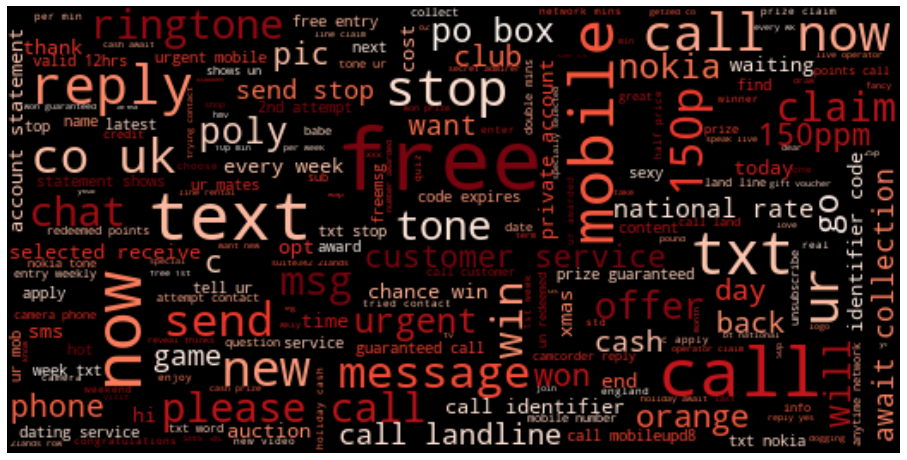

In [ ]:
spam_msg_cloud = WordCloud(width=520, 
                           height=260, 
                           margin=2, 
                           ranks_only=None,  
                           min_font_size=4, 
                           stopwords=STOPWORDS, 
                           background_color='black', 
                           max_font_size=50, 
                           colormap='Reds').generate(spam_msg_text)
plt.figure(figsize=(16,10))
plt.imshow(spam_msg_cloud,interpolation='bilinear')
plt.axis('off')
plt.show()

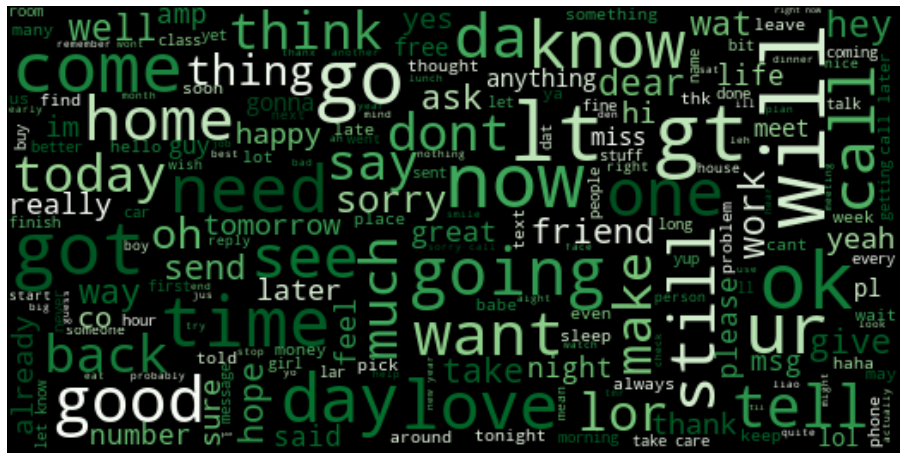

In [ ]:
ham_msg_cloud = WordCloud(width=520, 
                          height=260, 
                          stopwords=STOPWORDS, 
                          background_color='black', 
                          max_font_size=50, 
                          colormap="Greens").generate(ham_msg_text)
plt.figure(figsize=(16,10))
plt.imshow(ham_msg_cloud,interpolation='bilinear')
plt.axis('off')
plt.show()

Now we will explore the data to see if some imbalance

**Exploring the Dataset with `seaborn`**

In [ ]:
import seaborn as sns

We will check if the data is imbalance, in other words, check if we have more example of spam than ham or viceversa

shape of ham messages: (3619, 2)
shape of spam message: (560, 2)


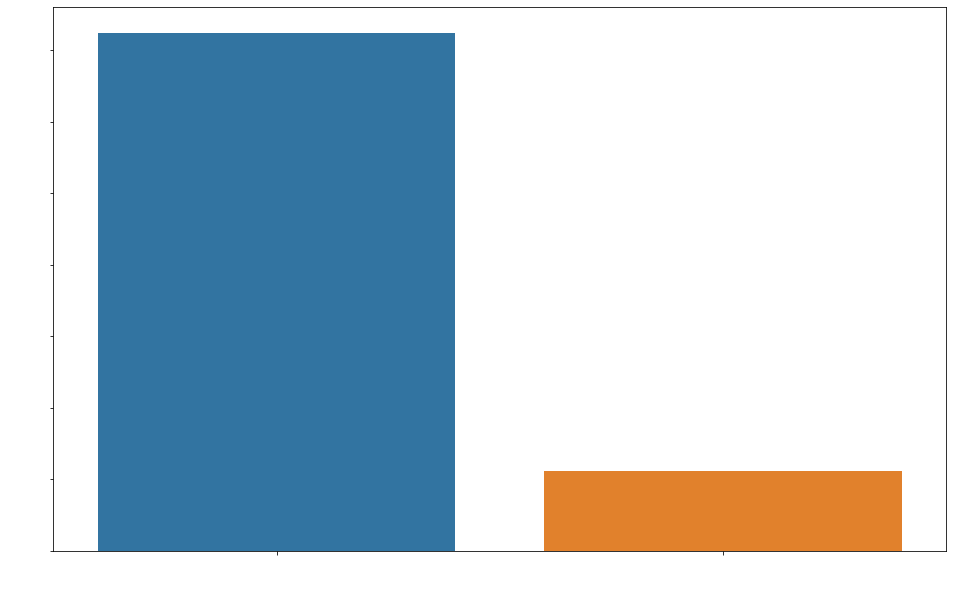

In [ ]:
plt.figure(figsize=(16,10))
countplot = sns.countplot(x=train_dataset['type_sms'], data= train_dataset)
plt.ylabel('number of message').set_color('white')
plt.yticks(color='white')
plt.xlabel('Message type').set_color('white')
plt.xticks(color='white')
print(f"shape of ham messages: {ham_msg.shape}\nshape of spam message: {spam_msg.shape}")

We can downsample `ham` to make the dataset a bit more balance, We will use the group create for the wordcloud, to create two new dataset:


*   `spam_msg = train_dataset[train_dataset.type_sms == 'spam']`  
* `ham_msg = train_dataset[train_dataset.type_sms == 'ham']`  



In [ ]:
ham_msg_dataset = ham_msg.sample(n=len(spam_msg), random_state=44)
spam_msg_dataset = spam_msg
print(f"ham dataset: {ham_msg_dataset.shape}\nspam_dataset: {spam_msg_dataset.shape}")

ham dataset: (560, 2)
spam_dataset: (560, 2)


Bellow we will use a trick, we will merge both datasets using append, but since each dataset has a index, we need to remove that index and reset the indes so the new dataset will have a proper index 

In [ ]:
# we need to drop the old index and rest it, otherwise we will have the old indexes or
#a column with the old index
final_spam_ham_dataset = ham_msg_dataset.append(spam_msg_dataset).reset_index(drop=True)
final_spam_ham_dataset

,type_sms,Message
0,ham,i want to go to perumbavoor
1,ham,hi:)did you asked to waheeda fathima about leave?
2,ham,get down in gandhipuram and walk to cross cut ...
3,ham,hey leave it. not a big deal:-) take care.
4,ham,dude got a haircut. now its breezy up there
...,...,...
1115,spam,free msg: single? find a partner in your area!...
1116,spam,free2day sexy st george's day pic of jordan!tx...
1117,spam,you are a winner you have been specially selec...
1118,spam,free entry into our £250 weekly competition ju...


(array([0, 1]), <a list of 2 Text major ticklabel objects>)

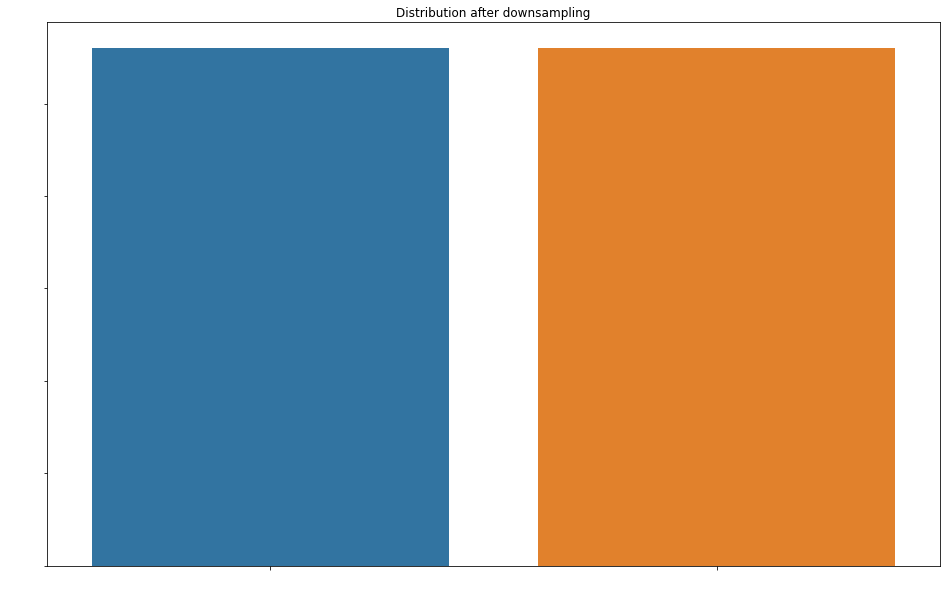

In [ ]:
#plot the new dataset
plt.figure(figsize=(16,10))
sns.countplot(x=final_spam_ham_dataset['type_sms'], data=final_spam_ham_dataset)
plt.title("Distribution after downsampling")
plt.ylabel('number of message').set_color('white')
plt.yticks(color='white')
plt.xlabel('Message type').set_color('white')
plt.xticks(color='white')

Now we need to change the categorical data to numerical, we can use `get_dummies()` or we can `map()` the values of the column `type_sms` to a value we want, in this case `ham` is `0` and `spam` is `1`.

In [ ]:
final_spam_ham_dataset['type_sms'] = final_spam_ham_dataset['type_sms'].map({'ham':0,'spam':1})

In [ ]:
final_spam_ham_dataset

,type_sms,Message
0,0,i want to go to perumbavoor
1,0,hi:)did you asked to waheeda fathima about leave?
2,0,get down in gandhipuram and walk to cross cut ...
3,0,hey leave it. not a big deal:-) take care.
4,0,dude got a haircut. now its breezy up there
...,...,...
1115,1,free msg: single? find a partner in your area!...
1116,1,free2day sexy st george's day pic of jordan!tx...
1117,1,you are a winner you have been specially selec...
1118,1,free entry into our £250 weekly competition ju...


## Pre-processing the data.

First we create a dataframe with just the message and other with just the label

In [ ]:
train_msg = final_spam_ham_dataset['Message']
train_label = final_spam_ham_dataset['type_sms'].values

### Tokenization

Tokenizer() does all the required pre-processing such as
* tokenize into word or character — here we use at 
word level
* num_words for maximum number of unique tokens 
* hence we can filter out rare words
* filter out punctuation terms
* convert all words to lower case
* convert all words to integer index

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

Now we can create the hyper-parameter to be use in the tokenization, sequencing and padding

In [ ]:
max_len = 50
trunc_type = 'post'
padding_type = 'post'
oov_tok = '<OOV>' # means out of the vocabulary
vocab_size = 500

In [ ]:
tokenizer = Tokenizer(num_words=vocab_size, char_level=False, oov_token=oov_tok)

In [ ]:
tokenizer.fit_on_texts(train_msg)

We can explore the tokenizer object and check the word index, in other words we assigned a index to each word

In [ ]:
word_index = tokenizer.word_index
word_index

{'<OOV>': 1,
 'to': 2,
 'you': 3,
 'a': 4,
 'i': 5,
 'call': 6,
 'the': 7,
 'your': 8,
 'u': 9,
 'for': 10,
 'now': 11,
 'is': 12,
 'and': 13,
 'free': 14,
 'or': 15,
 '2': 16,
 'in': 17,
 'have': 18,
 'on': 19,
 'of': 20,
 'ur': 21,
 'txt': 22,
 'are': 23,
 '4': 24,
 'with': 25,
 'from': 26,
 'me': 27,
 'get': 28,
 'just': 29,
 'mobile': 30,
 'this': 31,
 'my': 32,
 'text': 33,
 'stop': 34,
 'it': 35,
 'reply': 36,
 'no': 37,
 'www': 38,
 'be': 39,
 'will': 40,
 'we': 41,
 'do': 42,
 'only': 43,
 'not': 44,
 'so': 45,
 'out': 46,
 'claim': 47,
 'our': 48,
 'that': 49,
 'send': 50,
 'go': 51,
 'up': 52,
 'new': 53,
 'at': 54,
 'prize': 55,
 "i'm": 56,
 'if': 57,
 'week': 58,
 't': 59,
 'nokia': 60,
 'can': 61,
 'been': 62,
 'cash': 63,
 'uk': 64,
 '150p': 65,
 'all': 66,
 'win': 67,
 'how': 68,
 'know': 69,
 'com': 70,
 'but': 71,
 'when': 72,
 'day': 73,
 'co': 74,
 'won': 75,
 '1': 76,
 'tone': 77,
 'phone': 78,
 'who': 79,
 '50': 80,
 'time': 81,
 'service': 82,
 'back': 83,
 'by': 

### Sequencing and Padding

After tokinezed the items or sentences in the dataset, we need to transform that tokenized content in a sequence ( a sequences of numbers that represent the sentence)

In [ ]:
training_sequence = tokenizer.texts_to_sequences(train_msg)

In case the sequesnce is shorter or longer than the maximumg lenght definned, we pad or truncate the sequence, in this case we pad and truncate at the end of the sequence, or that reason the value of `post`

In [ ]:
training_padded = pad_sequences(training_sequence, 
                                maxlen=max_len, 
                                padding=padding_type,
                                truncating=trunc_type)

In [ ]:
print('And example of how it looks a padded sequence')
print(training_padded[0])

And example of how it looks a padded sequence
[ 5 99  2 51  2  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0]


The same process for the test data

In [ ]:
test_dataset['type_sms'] = test_dataset['type_sms'].map({'ham':0,'spam':1})
test_dataset

,type_sms,Message
0,0,i am in hospital da. . i will return home in e...
1,0,"not much, just some textin'. how bout you?"
2,0,i probably won't eat at all today. i think i'm...
3,0,don‘t give a flying monkeys wot they think and...
4,0,who are you seeing?
...,...,...
1387,0,true dear..i sat to pray evening and felt so.s...
1388,0,"what will we do in the shower, baby?"
1389,0,where are you ? what are you doing ? are yuou ...
1390,1,ur cash-balance is currently 500 pounds - to m...


In [ ]:
test_msg = test_dataset['Message']
test_label = test_dataset['type_sms'].values

In [ ]:
testing_sequence = tokenizer.texts_to_sequences(test_msg)

In [ ]:
testing_padded = pad_sequences(testing_sequence,
                               maxlen=max_len,
                               padding=padding_type,
                               truncating=trunc_type)

## Models 

Before start with the model we will import some classes and functions from tesnsorflow

In [ ]:
# Modeling 
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, GlobalAveragePooling1D, Dense, Dropout, LSTM, Bidirectional

### Dense Spam Detection Model 

First we define some hyper-parameter for the model

In [ ]:
vocab_size = 1000 # as defined early
embeding_dim = 16
drop_value = 0.2 #droupout
n_dense = 24

In [ ]:
dense_model = Sequential()
dense_model.add(Embedding(input_dim=vocab_size, 
                          output_dim=embeding_dim, 
                          input_length=max_len))
dense_model.add(GlobalAveragePooling1D())
dense_model.add(Dense(24, activation='relu'))
dense_model.add(Dropout(drop_value))
dense_model.add(Dense(1, activation='sigmoid'))

In [ ]:
dense_model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 50, 16)            16000     
_________________________________________________________________
global_average_pooling1d_1 ( (None, 16)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 24)                408       
_________________________________________________________________
dropout_1 (Dropout)          (None, 24)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 25        
Total params: 16,433
Trainable params: 16,433
Non-trainable params: 0
_________________________________________________________________


#### Compiling the Dense model

Since this is a binary selection we use `binary-crossentropy` as loss function 

In [ ]:
dense_model.compile(loss='binary_crossentropy',
                    optimizer='adam',
                    metrics=['accuracy'])

#### Training and Evaluation of Desne model

Here we will define the Number of `epoch` and the `callback` function, in this case the callback function will be a `EarlyStopping()` this early stoping will monitor the validation lost and if there are not improvementes in the number of epoch set in the parameter `patience` it will stop the training ( `EarlyStopping(monitor='val_loss', patience=2`).

In [ ]:
num_epoch = 50
early_stop = EarlyStopping(monitor='val_loss', patience=2)

In [ ]:
dense_history = dense_model.fit(x=training_padded, 
                                y=train_label, 
                                epochs=num_epoch,
                                validation_data=(testing_padded, test_label),
                                callbacks=[early_stop],
                                verbose=2)

Epoch 1/50
35/35 - 1s - loss: 0.6889 - accuracy: 0.5982 - val_loss: 0.6773 - val_accuracy: 0.9088
Epoch 2/50
35/35 - 0s - loss: 0.6740 - accuracy: 0.8250 - val_loss: 0.6636 - val_accuracy: 0.8427
Epoch 3/50
35/35 - 0s - loss: 0.6369 - accuracy: 0.8580 - val_loss: 0.6387 - val_accuracy: 0.8017
Epoch 4/50
35/35 - 0s - loss: 0.5681 - accuracy: 0.8723 - val_loss: 0.5825 - val_accuracy: 0.8218
Epoch 5/50
35/35 - 0s - loss: 0.4781 - accuracy: 0.8946 - val_loss: 0.4943 - val_accuracy: 0.8585
Epoch 6/50
35/35 - 0s - loss: 0.3879 - accuracy: 0.9054 - val_loss: 0.4090 - val_accuracy: 0.8822
Epoch 7/50
35/35 - 0s - loss: 0.3159 - accuracy: 0.9187 - val_loss: 0.3444 - val_accuracy: 0.9030
Epoch 8/50
35/35 - 0s - loss: 0.2639 - accuracy: 0.9330 - val_loss: 0.2800 - val_accuracy: 0.9246
Epoch 9/50
35/35 - 0s - loss: 0.2221 - accuracy: 0.9438 - val_loss: 0.2362 - val_accuracy: 0.9310
Epoch 10/50
35/35 - 0s - loss: 0.1908 - accuracy: 0.9545 - val_loss: 0.1967 - val_accuracy: 0.9404
Epoch 11/50
35/35 -

The model Accuracy is about 96% with the validation accuracy of 96%, que can further evaluate using the test dataset and `evaluate()`

In [ ]:
dense_model_output_loss, dense_model_output_acc = dense_model.evaluate(x=testing_padded,
                     y=test_label)
print('the output of the dense model')
print(f'loss: {dense_model_output_loss}, accuracy: {dense_model_output_acc}')

44/44 [==============================] - 0s 982us/step - loss: 0.1245 - accuracy: 0.9648
the output of the dense model
loss: 0.12452132254838943, accuracy: 0.9647988677024841


#### Plotting the loss and accuracy

In [ ]:
# create a new dataframe with the info of the model
dense_model_metrics = pd.DataFrame(dense_history.history)

In [ ]:
# remane the columns to later use them in the plotting 
dense_model_metrics.rename(columns={'loss': 'Training_Loss',
                                    'accuracy': 'Training_Accuracy',
                                    'val_loss': 'Validation_Loss',
                                    'val_accuracy':'Validation_Accuracy'}, 
                           inplace=True)

In [ ]:
# Defining a function to plot
def plot_graphs1(var1, var2, string):
    dense_model_metrics[[var1, var2]].plot()
    plt.title('Training and Validation ' + string).set_color('white')
    plt.xlabel ('Number of epochs').set_color('white')
    plt.xticks(color='white')
    plt.ylabel(string).set_color('white')
    plt.yticks(color='white')
    plt.legend([var1, var2])

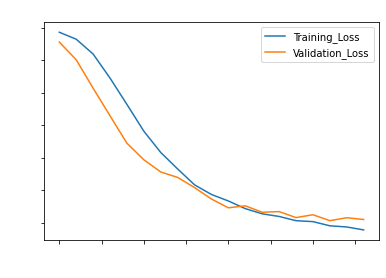

In [ ]:
plot_graphs1('Training_Loss','Validation_Loss','loss')

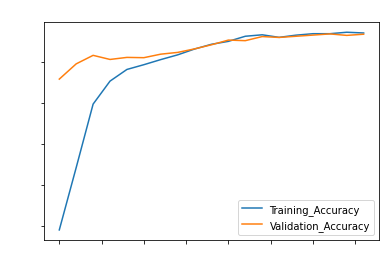

In [ ]:
plot_graphs1('Training_Accuracy','Validation_Accuracy','accuracy')

In [ ]:
dense_loss, dense_accuracy = dense_model.evaluate(x=testing_padded,
                                               y=test_label)
print(f'the Loss for Dense: {dense_loss} and the accuracy: {dense_accuracy}')

44/44 [==============================] - 0s 907us/step - loss: 0.1105 - accuracy: 0.9684
the Loss for Dense: 0.11050105839967728 and the accuracy: 0.9683908224105835


### Long Short Term Memory (LSTM) Model

Now for the LSTM model we will neeed to make 2 more hyper-parameter
* `n-lstm = 20` the number of nodes in the hidden layers within the LSTM cell.
* `return_sequence = True` as `True` we are telling the LSTM cell to rturns all the ouput of the LSTM cell through time,as `False` it will return just the privious oputput of the the previous step. 

In [ ]:
# LSTM Hyper parameters 
n_lstm = 20
drop_lstm = 0.2

#### The LSTM architecture

In [ ]:
lstm_model = Sequential()
lstm_model.add(Embedding(vocab_size,
                         embeding_dim,
                         input_length=max_len))
lstm_model.add(LSTM(n_lstm,
                    dropout=drop_lstm,
                    return_sequences=True))
lstm_model.add(LSTM(n_lstm,
                    dropout=drop_lstm,
                    return_sequences=True))
lstm_model.add(Dense(1, activation='sigmoid'))

#### Compiling the `LSTM model`

In [ ]:
lstm_model.compile(loss='binary_crossentropy',
                   optimizer='adam',
                   metrics=['accuracy'])

#### Training the LSTM model

In [ ]:
lstm_num_epochs = 30
lstm_early_stop = EarlyStopping(monitor='val_loss',
                                patience=2)
lstm_history = lstm_model.fit(x=training_padded,
                              y=train_label,
                              epochs=lstm_num_epochs,
                              validation_data=(testing_padded,test_label),
                              callbacks=[lstm_early_stop],
                              verbose=2)

Epoch 1/30
35/35 - 4s - loss: 0.6786 - accuracy: 0.6080 - val_loss: 0.5697 - val_accuracy: 0.6322
Epoch 2/30
35/35 - 1s - loss: 0.4208 - accuracy: 0.8208 - val_loss: 0.2605 - val_accuracy: 0.9363
Epoch 3/30
35/35 - 1s - loss: 0.2554 - accuracy: 0.9245 - val_loss: 0.2462 - val_accuracy: 0.9418
Epoch 4/30
35/35 - 1s - loss: 0.2150 - accuracy: 0.9358 - val_loss: 0.2224 - val_accuracy: 0.9465
Epoch 5/30
35/35 - 1s - loss: 0.1872 - accuracy: 0.9459 - val_loss: 0.2934 - val_accuracy: 0.9127
Epoch 6/30
35/35 - 1s - loss: 0.1670 - accuracy: 0.9481 - val_loss: 0.1831 - val_accuracy: 0.9532
Epoch 7/30
35/35 - 1s - loss: 0.1443 - accuracy: 0.9559 - val_loss: 0.1851 - val_accuracy: 0.9509
Epoch 8/30
35/35 - 1s - loss: 0.1349 - accuracy: 0.9564 - val_loss: 0.1647 - val_accuracy: 0.9554
Epoch 9/30
35/35 - 1s - loss: 0.1290 - accuracy: 0.9584 - val_loss: 0.2305 - val_accuracy: 0.9432
Epoch 10/30
35/35 - 1s - loss: 0.1288 - accuracy: 0.9590 - val_loss: 0.1887 - val_accuracy: 0.9518


#### Extrating data of the model performance

In [ ]:
# Creating the dataframe
lstm_metrics = pd.DataFrame(lstm_history.history)

#renaming the columns of the dataframe
lstm_metrics.rename(columns = {"loss":"Training_loss",
                               "accuracy": "Training_accuracy",
                               "val_loss": "Validation_loss",
                               "val_accuracy": "Validation_accuracy"},
                    inplace=True)

In [ ]:
def plot_graphs_lstm(var1, var2, string):
    lstm_metrics[[var1, var2]].plot()
    plt.title('Training and Validation ' + string).set_color('white')
    plt.xlabel ('Number of epochs').set_color('white')
    plt.xticks(color='white')
    plt.ylabel(string).set_color('white')
    plt.yticks(color='white')
    plt.legend([var1, var2])

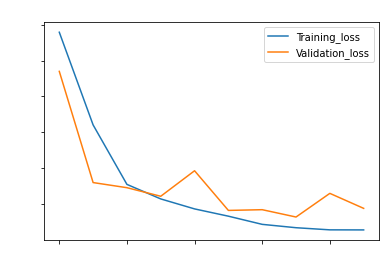

In [ ]:
plot_graphs_lstm('Training_loss','Validation_loss',"loss")

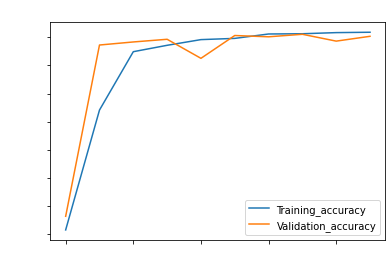

In [ ]:
plot_graphs_lstm('Training_accuracy','Validation_accuracy',"accuracy")

In [ ]:
lstm_loss, lstm_accuracy = lstm_model.evaluate(x=testing_padded,
                                               y=test_label)
print(f'the Loss for LSTM: {lstm_loss} and the accuracy: {lstm_accuracy}')

44/44 [==============================] - 0s 7ms/step - loss: 0.1887 - accuracy: 0.9518
the Loss for LSTM: 0.18874958157539368 and the accuracy: 0.9518103003501892


### Bi-directional Long Short Term Memory (BiLSTM) Model

The Bi-LSTM learns patterns from both before and after a given token within the document, Bi-LSTM back-propagates in both backwards and forwad direction of time. It will take more time for training, but in theory must give a better result than LSTM.

Bi-LSTM Architecture

In [ ]:
#Bi-Directional LSTM spam detection architecture
bi_lstm_model = Sequential()
bi_lstm_model.add(Embedding(input_dim=vocab_size,
                            output_dim=embeding_dim,
                            input_length=max_len))
bi_lstm_model.add(Bidirectional(LSTM(n_lstm,
                                     dropout=drop_lstm,
                                     return_sequences=True)))
bi_lstm_model.add(Dense(1, activation='sigmoid'))

#### Compiling `Bidirectional`

In [ ]:
bi_lstm_model.compile(loss='binary_crossentropy',
                      optimizer='adam',
                      metrics=['accuracy'])

#### Training the Bi-LSTM model

In [ ]:
bi_lstm_num_epochs = 30
bi_lstm_early_stop = EarlyStopping(monitor='val_loss', 
                           patience=2)

bi_lstm_history = bi_lstm_model.fit(x=training_padded,
                                    y=train_label,
                                    epochs=bi_lstm_num_epochs,
                                    validation_data=(testing_padded,test_label),
                                    callbacks=[bi_lstm_early_stop],
                                    verbose=2)

Epoch 1/30
35/35 - 4s - loss: 0.6842 - accuracy: 0.5939 - val_loss: 0.6212 - val_accuracy: 0.7550
Epoch 2/30
35/35 - 1s - loss: 0.5214 - accuracy: 0.7754 - val_loss: 0.2706 - val_accuracy: 0.9248
Epoch 3/30
35/35 - 1s - loss: 0.2403 - accuracy: 0.9361 - val_loss: 0.2094 - val_accuracy: 0.9465
Epoch 4/30
35/35 - 1s - loss: 0.1718 - accuracy: 0.9513 - val_loss: 0.2585 - val_accuracy: 0.9333
Epoch 5/30
35/35 - 1s - loss: 0.1416 - accuracy: 0.9608 - val_loss: 0.1141 - val_accuracy: 0.9733
Epoch 6/30
35/35 - 1s - loss: 0.1256 - accuracy: 0.9662 - val_loss: 0.1938 - val_accuracy: 0.9562
Epoch 7/30
35/35 - 1s - loss: 0.0993 - accuracy: 0.9754 - val_loss: 0.2048 - val_accuracy: 0.9552


Extrating data from Bi-LSTM performance

In [ ]:
bi_lstm_metrics = pd.DataFrame(bi_lstm_history.history)
bi_lstm_metrics.rename(columns={"loss":"Training_loss",
                               "accuracy": "Training_accuracy",
                               "val_loss": "Validation_loss",
                               "val_accuracy": "Validation_accuracy"},
                    inplace=True)

In [ ]:
def plot_graphs_bi_lstm(var1, var2, string):
    bi_lstm_metrics[[var1, var2]].plot()
    plt.title('Training and Validation ' + string).set_color('white')
    plt.xlabel ('Number of epochs').set_color('white')
    plt.xticks(color='white')
    plt.ylabel(string).set_color('white')
    plt.yticks(color='white')
    plt.legend([var1, var2])

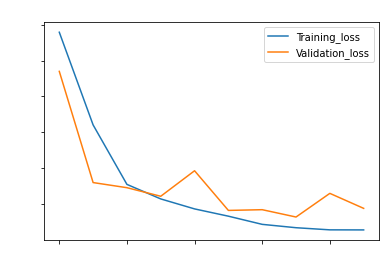

In [ ]:
plot_graphs_lstm('Training_loss','Validation_loss',"loss")

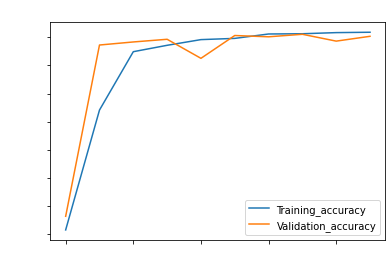

In [ ]:
plot_graphs_lstm('Training_accuracy','Validation_accuracy',"accuracy")

In [ ]:
bi_lstm_loss, bi_lstm_accuracy = bi_lstm_model.evaluate(x=testing_padded,
                                               y=test_label)
print(f'the Loss for Bi-LSTM: {bi_lstm_loss} and the accuracy: {bi_lstm_accuracy}')

44/44 [==============================] - 0s 5ms/step - loss: 0.2048 - accuracy: 0.9552
the Loss for Bi-LSTM: 0.20476749539375305 and the accuracy: 0.9551581740379333


## Compering the 3 models

In [ ]:
print(f'the Loss for Dense: {dense_loss} and the accuracy: {dense_accuracy}')
print(f'the Loss for LSTM: {lstm_loss} and the accuracy: {lstm_accuracy}')
print(f'the Loss for Bi-LSTM: {bi_lstm_loss} and the accuracy: {bi_lstm_accuracy}')

the Loss for Dense: 0.11050105839967728 and the accuracy: 0.9683908224105835
the Loss for LSTM: 0.18874958157539368 and the accuracy: 0.9518103003501892
the Loss for Bi-LSTM: 0.20476749539375305 and the accuracy: 0.9551581740379333


## Prediction_message function

In [ ]:
# function to predict messages based on model
# (should return list containing prediction and label, ex. [0.008318834938108921, 'ham'])
def predict_message(pred_text):
    predict_sequence = tokenizer.texts_to_sequences([pred_text])
    predict_padded = pad_sequences(predict_sequence,
                                   maxlen=max_len,
                                   padding=padding_type,
                                   truncating=trunc_type)
    # print(predict_padded)
    prediction_raw = dense_model.predict(predict_padded) 
    prediction_rounded = round(prediction_raw[0][0] * 2) / 2
    if prediction_rounded >= 0.5:
        prediction = [prediction_raw[0][0], 'spam']
    else: 
        prediction = [prediction_raw[0][0], 'ham']
    print(f'\nthe original sentece:\n{pred_text}')
    print(f'the sequence:\n{predict_sequence}')
    print(f'the padded sequence:\n{predict_padded}')
    return prediction

pred_text = "how are you doing today"
print(prediction)


the original sentece:
how are you doing today
the sequence:
[[68, 23, 3, 266, 109]]
the padded sequence:
[[ 68  23   3 266 109   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0]]
[0.017090619, 'ham']

the original sentece:
sale today! to stop texts call 98912460324
the sequence:
[[1, 109, 2, 34, 304, 6, 1]]
the padded sequence:
[[  1 109   2  34 304   6   1   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0]]
[0.43416876, 'spam']

the original sentece:
i dont want to go. can we try it a different day? available sat
the sequence:
[[5, 146, 99, 2, 51, 61, 41, 458, 35, 4, 1, 73, 1, 1]]
the padded sequence:
[[  5 146  99   2  51  61  41 458  35   4   1  73   1   1   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0  

In [ ]:
# Run this cell to test your function and model. Do not modify contents.
def test_predictions():
  test_messages = ["how are you doing today",
                   "sale today! to stop texts call 98912460324",
                   "i dont want to go. can we try it a different day? available sat",
                   "our new mobile video service is live. just install on your phone to start watching.",
                   "you have won £1000 cash! call to claim your prize.",
                   "i'll bring it tomorrow. don't forget the milk.",
                   "wow, is your arm alright. that happened to me one time too"
                  ]

  test_answers = ["ham", "spam", "ham", "spam", "spam", "ham", "ham"]
  passed = True

  for msg, ans in zip(test_messages, test_answers):
    prediction = predict_message(msg)
    if prediction[1] != ans:
      passed = False

  if passed:
    print("You passed the challenge. Great job!")
  else:
    print("You haven't passed yet. Keep trying.")

test_predictions()


how are you doing today
[[68, 23, 3, 266, 109]]
sale today! to stop texts call 98912460324
[[1, 109, 2, 34, 304, 6, 1]]
i dont want to go. can we try it a different day? available sat
[[5, 146, 99, 2, 51, 61, 41, 458, 35, 4, 1, 73, 1, 1]]
our new mobile video service is live. just install on your phone to start watching.
[[48, 53, 30, 141, 82, 12, 182, 29, 1, 19, 8, 78, 2, 1, 1]]
you have won £1000 cash! call to claim your prize.
[[3, 18, 75, 149, 63, 6, 2, 47, 8, 55]]
i'll bring it tomorrow. don't forget the milk.
[[330, 1, 35, 153, 174, 1, 7, 1]]
wow, is your arm alright. that happened to me one time too
[[1, 12, 8, 1, 1, 49, 1, 2, 27, 130, 81, 206]]
You passed the challenge. Great job!
